# Chapter 3: Data Pre-processing

**3.1 The UC Irvine Machine Learning Repository contains a data set related to glass identification.**

**(a) Using visualizations, explore the predictor variables to understand their distributions as well as the relationships between predictors.**

**(b) Do there appear to be any outliers in the data? Are any predictors skewed?**

**(c) Are there any relevant transformations of one or more predictors that might improve the classification model?**

In [54]:
library(mlbench)
data(Glass)
dim(Glass)
head(Glass)

[1] 214  10

RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0.00,1
1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0.00,1
1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0.00,1
1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0.00,1
1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0.00,1
1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0,0.26,1


In [74]:
# First thing's first, let's look at the types for each column
sapply(Glass, class)

RI        Na        Mg        Al        Si         K        Ca        Ba 
"numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" "numeric" 
       Fe      Type 
"numeric"  "factor"

In [77]:
library(e1071)
library(dplyr)

# Let's check various moments of the data (ignoring `Type`, since it's a factor)
predictors <- select(Glass, -Type)
moments <- data.frame(num.NA = sapply(predictors, function(x) sum(is.na(x))),
                      mean = sapply(predictors, mean, na.rm=TRUE),
                      sd = sapply(predictors, sd, na.rm=TRUE),
                      skew = sapply(predictors, skewness))
    
moments

,num.NA,mean,sd,skew
RI,0,1.51836542,0.003036864,1.6027151
Na,0,13.40785047,0.816603556,0.4478343
Mg,0,2.68453271,1.442407845,-1.1364523
Al,0,1.44490654,0.499269646,0.8946104
Si,0,72.65093458,0.774545795,-0.7202392
K,0,0.49705607,0.652191846,6.4600889
Ca,0,8.95696262,1.423153487,2.0184463
Ba,0,0.17504673,0.497219261,3.3686800
Fe,0,0.05700935,0.097438701,1.7298107


It looks like there are a few columns that have high skew (and might benefit from Box Cox or log transforms). Let's see if there are any highly correlated variables.

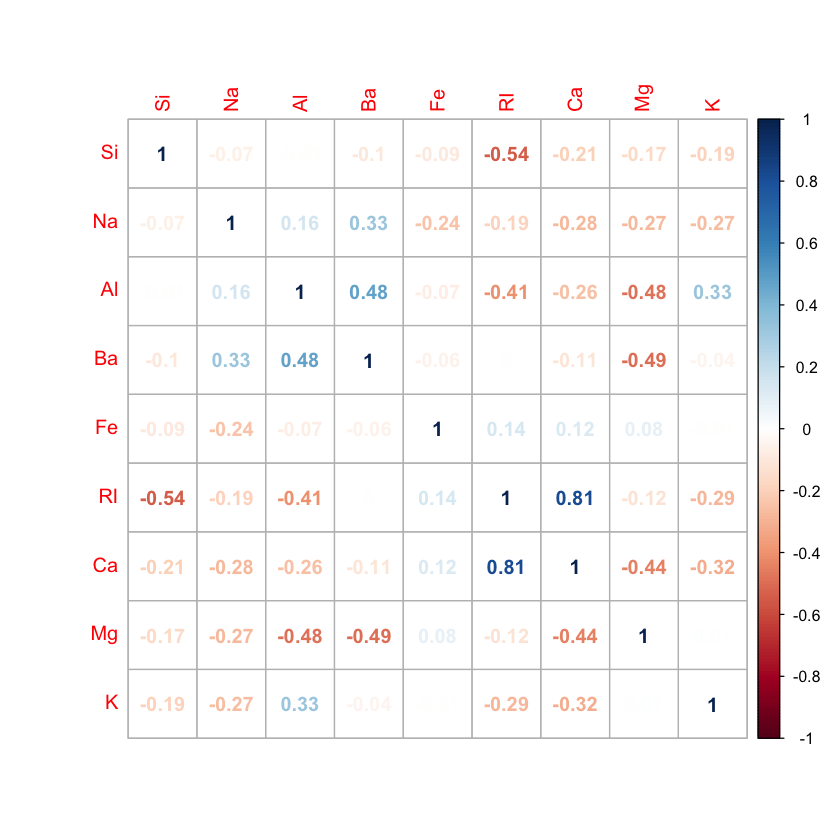

In [88]:
library(caret)
library(corrplot)

corrplot(cor(predictors), method='number', order='hclust')

In [91]:
# It seems like there's at least one pair of predictors (RI, Ca) that has high correlation.
# Let's see if there are any near zero variance columns
print(paste('Near Zero Variance:', nearZeroVar(predictors)))

[1] "Near Zero Variance: "


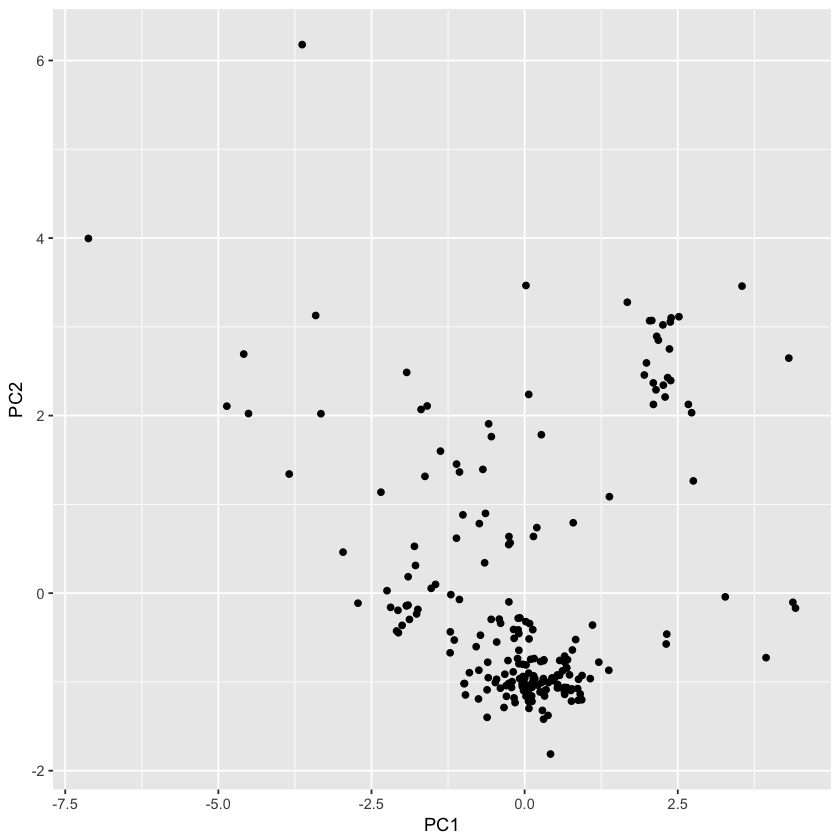

In [118]:
# Run PCA on the data to see if there are any outliers
pca.object <- prcomp(predictors, center = TRUE, scale = TRUE)

library(ggplot2)
ggplot(as.data.frame(pca.object$x), aes(x=PC1, y=PC2)) +
    geom_point()

In [127]:
# It seems like there's a couple of outliers. Let's identify a few of them
x.pca <- as.data.frame(pca.object$x)
outliers <- (x.pca$PC1 < -5.0) | (x.pca$PC2 > 6.0)

Let's make a plain vanilla, then compare it against various transforms.

In [139]:
# We will use CV to test efficacy of the model
tr.control <- trainControl(method='LOOCV')

# Plain vanilla model.
fit <- train(Type ~ ., data=Glass, trControl=tr.control, method='lda')
print(paste('Vanilla model:', fit$results$Accuracy))

# Remove high correlation variables
fit <- train(Type ~ . - Ca, data=Glass, trControl=tr.control, method='lda')
print(paste('W/o High correlation:', fit$results$Accuracy))

# Log transform high skew variables
fit <- train(Type ~ . + I(log(K + 1)) + I(log(Ba + 1)) - K - Ba, data=Glass, trControl=tr.control, method='lda')
print(paste('Log transformed:', fit$results$Accuracy))

# Remove outliers
fit <- train(Type ~ ., data=Glass[!outliers, ], trControl=tr.control, method='lda')
print(paste('Remove outliers:', fit$results$Accuracy))

# All together
fit <- train(Type ~ ., data=Glass[!outliers, ], trControl=tr.control, method='lda')
print(paste('Everything:', fit$results$Accuracy))

[1] "Vanilla model: 0.644859813084112"
[1] "W/o High correlation: 0.616822429906542"
[1] "Log transformed: 0.565420560747664"
[1] "Remove outliers: 0.636792452830189"
[1] "Everything: 0.636792452830189"


It seems that this problem has such small dimensionality and sample size that the typical preprocessing techniques of removing outliers or features is too restrictive. Instead let's look at transforms that keep the data rather than removing it.

In [147]:
fit <- train(Type ~ ., data=Glass, trControl=tr.control,
             preProcess=c('BoxCox', 'center', 'scale', 'spatialSign'), method='lda')
print(paste('Fancy transforms:', fit$results$Accuracy))

[1] "Fancy transforms: 0.710280373831776"


**3.2 Soybean data**

**(a) Investigate the frequency distribution for the categorical predictors. Are any of the distribution degenerate in the ways discussed earlier in this chapter?**

**(b) Roughly 18% of the data are missing. Are there particular predictors that are more likely to be missing? Is the pattern of missing data related to the classes?**

**(c) Develop a strategy for handling missing data, either by eliminating predictors or imputation.**

In [148]:
library(mlbench)
data(Soybean)

In [151]:
dim(Soybean)
head(Soybean)

[1] 683  36

Class,date,plant.stand,precip,temp,hail,crop.hist,area.dam,sever,seed.tmt,⋯,int.discolor,sclerotia,fruit.pods,fruit.spots,seed,mold.growth,seed.discolor,seed.size,shriveling,roots
diaporthe-stem-canker,6,0,2,1,0,1,1,1,0,⋯,0,0,0,4,0,0,0,0,0,0
diaporthe-stem-canker,4,0,2,1,0,2,0,2,1,⋯,0,0,0,4,0,0,0,0,0,0
diaporthe-stem-canker,3,0,2,1,0,1,0,2,1,⋯,0,0,0,4,0,0,0,0,0,0
diaporthe-stem-canker,3,0,2,1,0,1,0,2,0,⋯,0,0,0,4,0,0,0,0,0,0
diaporthe-stem-canker,6,0,2,1,0,2,0,1,0,⋯,0,0,0,4,0,0,0,0,0,0
diaporthe-stem-canker,5,0,2,1,0,3,0,1,0,⋯,0,0,0,4,0,0,0,0,0,0


In [154]:
# Let's see how much missing data there is for each column
sapply(Soybean, function(x) sum(is.na(x)))

Class            date     plant.stand          precip            temp 
              0               1              36              38              30 
           hail       crop.hist        area.dam           sever        seed.tmt 
            121              16               1             121             121 
           germ    plant.growth          leaves       leaf.halo       leaf.marg 
            112              16               0              84              84 
      leaf.size     leaf.shread       leaf.malf       leaf.mild            stem 
             84             100              84             108              16 
        lodging    stem.cankers   canker.lesion fruiting.bodies       ext.decay 
            121              38              38             106              38 
       mycelium    int.discolor       sclerotia      fruit.pods     fruit.spots 
             38              38              38              84             106 
           seed     mold.growth   seed.discolor       seed.size      shriveling 
             92              92             106              92             106 
          roots 
             31

In [162]:
summary(Soybean)

                 Class          date     plant.stand  precip      temp    
 brown-spot         : 92   5      :149   0   :354    0   : 74   0   : 80  
 alternarialeaf-spot: 91   4      :131   1   :293    1   :112   1   :374  
 frog-eye-leaf-spot : 91   3      :118   NA's: 36    2   :459   2   :199  
 phytophthora-rot   : 88   2      : 93               NA's: 38   NA's: 30  
 anthracnose        : 44   6      : 90                                    
 brown-stem-rot     : 44   (Other):101                                    
 (Other)            :233   NA's   :  1                                    
   hail     crop.hist  area.dam    sever     seed.tmt     germ     plant.growth
 0   :435   0   : 65   0   :123   0   :195   0   :305   0   :165   0   :441    
 1   :127   1   :165   1   :227   1   :322   1   :222   1   :213   1   :226    
 NA's:121   2   :219   2   :145   2   : 45   2   : 35   2   :193   NA's: 16    
            3   :218   3   :187   NA's:121   NA's:121   NA's:112               


We see that some predictors are more likely to be missing than others. There are also some possibly degenerate predictors, such as "mycelium" and "leaf.mild". Let's look at the missing data broken out by the class.

Warning message:
“attributes are not identical across measure variables; they will be dropped”

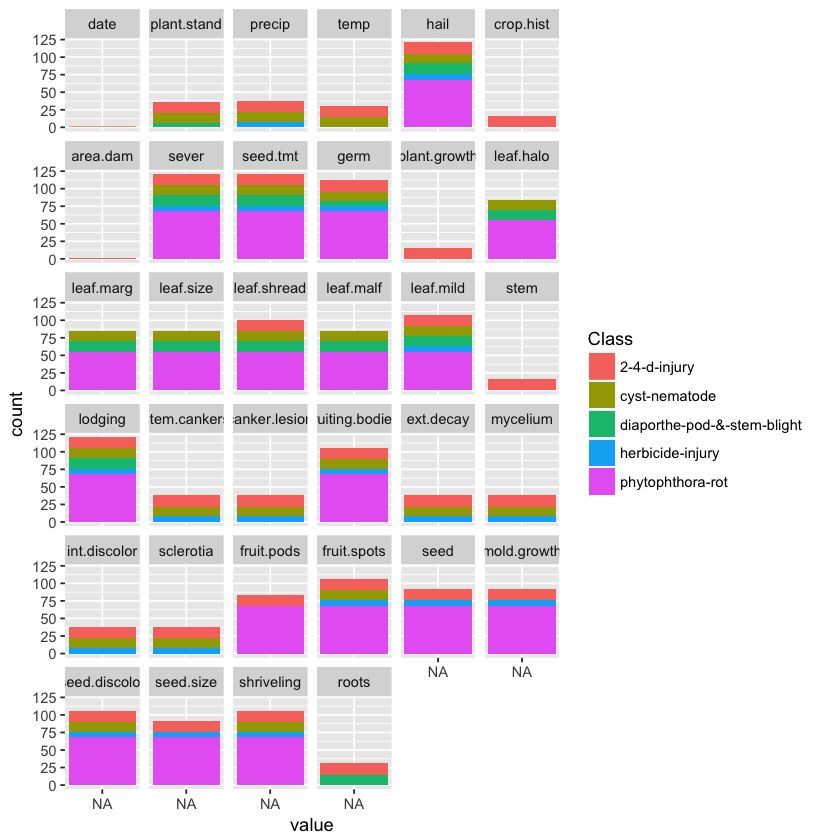

In [178]:
library(ggplot2)

ggplot(melt(Soybean, id='Class') %>% filter(is.na(value)), aes(fill=Class)) +
    geom_bar(aes(x=value)) +
    facet_wrap(~ variable)

It looks like not all missing values are created equal, with respect to the target variable. "phytophtora-rot" is very overrepresented in the missing values. In fact, only 5 target values account for all missing values, even though there are more classes than this. Let's run an ANOVA analysis to see if in fact the data is not missing at random.

In [188]:
df <- Soybean
df$has.NA <- apply(Soybean, 1, function(x) sum(is.na(x)))

anova(lm(has.NA ~ Class, data=df))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
Class,18,34760.091,1931.116173,240.9148,1.012083e-276
Residuals,664,5322.468,8.015765,NA,NA


The evidence is overwhelming that the data is not missing at random.

**Strategy to handle missing data:**

Since the data is not missing at random, we should not throw out missing entries. We either either impute the missing data using a method such as kNN, or median. Afterwards, we can add an indicator variable "wasNA", which will encode whether this row had missing data. Since data is not missing at random, this variable may be effective.